In [1]:
import os
import math
from math import sqrt

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [2]:
EPS = 1.0e-7

In [3]:

class Encoder(nn.Module):
    def __init__(self, D, M, C):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(D, M * 2),
            nn.BatchNorm1d(M * 2),
            nn.ReLU(),
            nn.Linear(M * 2, M),
            nn.BatchNorm1d(M),
            nn.ReLU(),
            nn.Linear(M, M // 2),
            nn.BatchNorm1d(M // 2),
            nn.ReLU(),
            nn.Linear(M // 2, C),
        )

    def forward(self, x):
        return self.encode(x)


class Decoder(nn.Module):
    def __init__(self, D, M, C):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(C, M // 2),
            nn.BatchNorm1d(M // 2),
            nn.ReLU(),
            nn.Linear(M // 2, M),
            nn.BatchNorm1d(M),
            nn.ReLU(),
            nn.Linear(M, M * 2),
            nn.BatchNorm1d(M * 2),
            nn.ReLU(),
            nn.Linear(M * 2, D),
        )

    def forward(self, x):
        return self.decode(x)


class Quantizer(nn.Module):
    def __init__(self, input_dim, codebook_dim, temp=1.0e7):
        super(Quantizer, self).__init__()
        self.temp = temp
        self.input_dim = input_dim
        self.codebook_dim = codebook_dim
        self.codebook = nn.Parameter(
            torch.FloatTensor(
                1,
                self.codebook_dim,
            ).uniform_(-1 / self.codebook_dim, 1 / self.codebook_dim)
        )

    def indices2codebook(self, indices_onehot):
        return torch.matmul(indices_onehot, self.codebook.t()).squeeze()

    def indices_to_onehot(self, inputs_shape, indices):
        indices_hard = torch.zeros(inputs_shape[0], inputs_shape[1], self.codebook_dim)
        indices_hard.scatter_(2, indices, 1)

    def forward(self, inputs):
        inputs_shape = inputs.shape
        inputs_repeat = inputs.unsqueeze(2).repeat(1, 1, self.codebook_dim)
        distances = torch.exp(
            -torch.sqrt(torch.pow(inputs_repeat - self.codebook.unsqueeze(1), 2))
        )
        indices = torch.argmax(distances, dim=2).unsqueeze(2)
        indices_hard = self.indices_to_onehot(
            inputs_shape=inputs_shape, indices=indices
        )
        indices_soft = torch.softmax(self.temp * distances, -1)
        quantized = self.indices2codebook(indices_onehot=indices_soft)
        return (indices_soft, indices_hard, quantized)


class Uniform_Entropy_Coding(nn.Module):
    def __init__(self, code_dim, codebook_dim):
        super(Uniform_Entropy_Coding, self).__init__()
        self.code_dim = code_dim
        self.codebook_dim = codebook_dim
        self.probs = torch.softmax(torch.ones(1, self.code_dim, self.codebook_dim), -1)

    def sample(self, quantizer=None, B=10):
        code = torch.zeros(B, self.code_dim, self.codebook_dim)
        for b in range(B):
            indx = torch.multinomial(
                torch.softmax(self.probs, -1).squeeze(0), 1
            ).squeeze()
            for i in range(self.code_dim):
                code[b, i, indx[i]] = 1

        code = quantizer.indices2codebook(code)
        return code

    def forward(self, z, x=None):
        p = torch.clamp(self.probs, EPS, 1.0 - EPS)
        return -torch.sum(z * torch.log(p), 2)


class Independent_Entropy_Coding(nn.Module):
    def __init__(self, code_dim, codebook_dim):
        super(Independent_Entropy_Coding, self).__init__()
        self.code_dim = code_dim
        self.codebook_dim = codebook_dim

        self.probs = nn.Parameter(torch.ones(1, self.code_dim, self.codebook_dim))

    def sample(self, quantizer=None, B=10):
        code = torch.zeros(B, self.code_dim, self.codebook_dim)
        for b in range(B):
            indx = torch.multinomial(
                torch.softmax(self.probs, -1).squeeze(0), 1
            ).squeeze()
            for i in range(self.code_dim):
                code[b, i, indx[i]] = 1

        code = quantizer.indices2codebook(code)
        return code

    def forward(self, z, x=None):
        p = torch.clamp(torch.softmax(self.probs, -1), EPS, 1.0 - EPS)
        return -torch.sum(z * torch.log(p), 2)


class Casual_Conv1d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        dilation,
        stride=1,
        A=False,
        **kwargs
    ):
        super(Casual_Conv1d, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A
        self.padding = (kernel_size - 1) * dilation + A * 1
        self.conv1d = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            dilation=dilation,
            **kwargs
        )

    def forward(self, x):
        x = nn.functional.pad(x, (self.padding, 0))
        x = self.conv1d(x)
        if self.A:
            return x[:, :, :-1]
        else:
            return x


class ARM_Entropy_Coding(nn.Module):
    def __init__(self, code_dim, codebook_dim, E=8, M_kernels=32, kernel=4):
        super(ARM_Entropy_Coding, self).__init__()
        self.code_dim = code_dim
        self.codebook_dim = codebook_dim
        self.arm_net = nn.Sequential(
            Casual_Conv1d(
                in_channels=1,
                out_channels=M_kernels,
                dilation=1,
                kernel_size=kernel,
                A=True,
                bias=True,
            ),
            nn.LeakyReLU(),
            Casual_Conv1d(
                in_channels=M_kernels,
                out_channels=M_kernels,
                dilation=1,
                kernel_size=kernel,
                A=False,
                bias=True,
            ),
            nn.LeakyReLU(),
            Casual_Conv1d(
                in_channels=M_kernels,
                out_channels=E,
                dilation=1,
                kernel_size=kernel,
                A=False,
                bias=True,
            ),
        )

    def f(self, x):
        h = self.arm_net(x.unsqueeze(1))
        # print("h_size", h.size())
        h = h.permute(0, 2, 1)
        # print("h_size", h.size())
        p = torch.softmax(h, 2)
        # print("p_size", p.size())

        return p

    def sample(self, quantizer=None, B=10):
        x_new = torch.zeros((B, self.code_dim))

        for d in range(self.code_dim):
            p = self.f(x_new)
            indx_d = torch.multinomial(p[:, d, :], num_samples=1)
            codebook_value = quantizer.codebook[0, indx_d].squeeze()
            x_new[:, d] = codebook_value

        return x_new

    def forward(self, z, x):
        p = self.f(x)
        return -torch.sum(z * torch.log(p), 2)


class Neural_Compressor(nn.Module):
    def __init__(
        self, encoder, decoder, entropy_coding, quantizer, beta=1, detaching=False
    ):
        super(Neural_Compressor, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.entropy_coding = entropy_coding
        self.quantizer = quantizer
        self.beta = beta
        self.detaching = detaching

    def forward(self, x, reduction="avg"):
        z = self.encoder(x)
        quantizer_out = self.quantizer(z)
        x_rec = self.decoder(quantizer_out[2])

        Distortion = torch.mean(torch.pow(x - x_rec, 2), (1))

        Rate = torch.mean(self.entropy_coding(quantizer_out[0], quantizer_out[2]), 1)
        objective = Distortion + self.beta * Rate

        if reduction == "sum":
            return objective.sum(), Distortion.sum(), Rate.sum()
        else:
            return objective.mean(), Distortion.mean(), Rate.mean()


In [4]:
D = 64
C = 16
E = 8
M = 256
M_kernels = 32
kernel = 4
entropy_coding_type = 'arm'
lr = 1e-3
num_epochs = 1000
max_patience = 50
beta = 1


encoder = Encoder(D=D, M=M, C=C)

decoder = Decoder(D=D, M=M, C=C)

quantizer = Quantizer(input_dim=C, codebook_dim=E)

kernel = 4
entropy_coding = ARM_Entropy_Coding(
    code_dim=C,
    codebook_dim=E,
    E=E,
    M_kernels=M_kernels,
    kernel=kernel,
)


model = Neural_Compressor(encoder=encoder, decoder=decoder, entropy_coding=entropy_coding, quantizer=quantizer, beta=beta )

In [5]:
#load model type .model by pytorch
model = torch.load('/workspace/nttrang2108/VHT/Image_Neural_Compression/weights/img_8/img_8_cus/best_model_440_D_64_C_16_E_8_M_256_loss_13.1994.model')

In [6]:
model.eval()

Neural_Compressor(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=512, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=128, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=128, out_features=256, bias=True)
      (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, a

In [7]:
class Digits(Dataset):
    def __init__(self, mode ='train', transforms = None):
        digits = load_digits()
        if mode =='train':
            self.data =digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            self.data = digits.data[1350:].astype(np.float32)
        
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [8]:
test_data = Digits(mode = 'test')

torch.Size([4, 64])


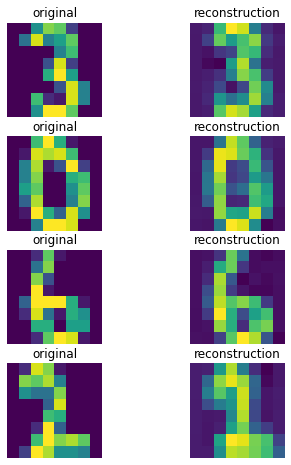

In [9]:
IMG_IDs = [110, 120, 130, 140]
z_sampled = model.entropy_coding.sample(quantizer=model.quantizer, B = 9)
x_sampled = model.decoder(z_sampled)

x_real = torch.from_numpy(test_data.__getitem__(IMG_IDs))
print(x_real.shape)
x_encoder = model.encoder(x_real)
# print(x_encoder)
# print("-----", model.quantizer(model.encoder(x_real)))
x_rec = model.decoder(model.quantizer(model.encoder(x_real))[-1])

fig, axs = plt.subplots(4, 2, figsize=(6, 8))
i = 0
for i in range(len(IMG_IDs)):
    axs[i,0].imshow(x_real[i].reshape(8,8).detach().numpy())
    axs[i,0].set_title('original')
    axs[i,0].axis('off')
    
    axs[i,1].imshow(x_rec[i].reshape(8,8).detach().numpy())
    axs[i,1].set_title('reconstruction')
    axs[i,1].axis('off')
    